In [2]:
%cd drive/MyDrive/CS273B Final Project

/content/drive/MyDrive/CS273B Final Project


In [3]:
!ls

'Attention U-Net Version 2.ipynb'
 dataset
 dataset-20240603T151808Z-001.zip
'dataset U-NET'
 Kaggle_Attention_UNET_Implementation.ipynb
 stage1_solution_combined_masks-20240603T144926Z-001.zip
 stage1_test_data-20240603T145431Z-001.zip
 U-NET_Implementation_Version_2.h5
'U-Net-Implementation Version 2.ipynb'


In [4]:
import cv2
import numpy as np
from glob import glob
from matplotlib import pylab as plt


In [5]:
import cv2
import numpy as np
from glob import glob

def load_train():
    path1 = sorted(glob('dataset/non-aug/train/images/*'))
    path2 = sorted(glob('dataset/non-aug/train/masks/*'))

    train_images = []
    train_labels = []

    count = 0
    num_images_and_masks_to_load = len(path1)
    for filename1, filename2 in zip(path1, path2):
        img1 = cv2.imread(filename1, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(filename2, cv2.IMREAD_GRAYSCALE)

        # Resize the images to 128x128
        img1 = cv2.resize(img1, (128, 128))
        img2 = cv2.resize(img2, (128, 128))

        # Add a channel dimension
        img1 = img1.reshape(128, 128, 1)
        img2 = img2.reshape(128, 128, 1)

        train_images.append(img1)
        train_labels.append(img2)

        count += 1
        if count % 10 == 0 or count == num_images_and_masks_to_load:
          print("Total number of images processed: " + str(count) + "/" + str(num_images_and_masks_to_load))

    # Normalize the image data to 0-1
    train_images = np.array(train_images) / 255.0
    train_labels = np.array(train_labels) / 255.0

    return train_images, train_labels

# Now you can load your train images and labels
# train_images, train_labels = load_train()
# print(train_images.shape)  # Should now be (N, 128, 128, 1) where N is the number of images


In [15]:
def load_train():
  path1=sorted(glob('dataset/non-aug/train/images/*'))
  path2=sorted(glob('dataset/non-aug/train/masks/*'))

  train_images=[]
  train_labels=[]
  for filename1,filename2 in zip(path1,path2):
    img1=cv2.imread(filename1, cv2.IMREAD_GRAYSCALE)
    img2=cv2.imread(filename2, cv2.IMREAD_GRAYSCALE)
    img1=img1[...,::-1]
    img1=img1.reshape(128,128,1)
    img2=img2[...,::-1]
    img2=img2.reshape(128,128,1)
    train_images.append(img1)
    train_labels.append(img2)

  train_images=np.array(train_images)/255
  train_labels=np.array(train_labels)/255

  return train_images,train_labels


In [6]:
train_images,train_labels=load_train()
print(train_images.shape)

Total number of images processed: 10/536
Total number of images processed: 20/536
Total number of images processed: 30/536
Total number of images processed: 40/536
Total number of images processed: 50/536
Total number of images processed: 60/536
Total number of images processed: 70/536
Total number of images processed: 80/536
Total number of images processed: 90/536
Total number of images processed: 100/536
Total number of images processed: 110/536
Total number of images processed: 120/536
Total number of images processed: 130/536
Total number of images processed: 140/536
Total number of images processed: 150/536
Total number of images processed: 160/536
Total number of images processed: 170/536
Total number of images processed: 180/536
Total number of images processed: 190/536
Total number of images processed: 200/536
Total number of images processed: 210/536
Total number of images processed: 220/536
Total number of images processed: 230/536
Total number of images processed: 240/536
T

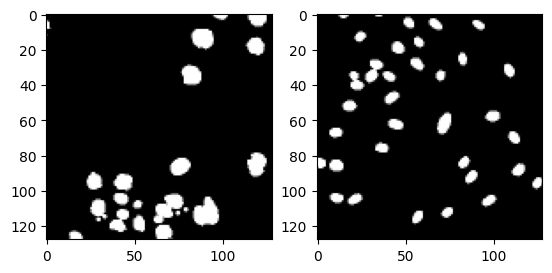

In [7]:
fig=plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(train_labels[i].reshape(128,128),cmap='gray')

In [8]:
# Work on this later:

def load_test(batch_size):
  path1 = sorted(glob('dataset/non-aug/test/images/*'))
  path2 = sorted(glob('dataset/non-aug/test/masks/*'))

  batch=np.random.choice(path,size=batch_size)
  test_images=[]
  for filename in batch:
    img=cv2.imread(filename, cv2.IMREAD_COLOR)
    img=img[...,::-1]
    img=img.reshape(128,128,3)
    test_images.append(img)

  test_images=np.array(test_images)/255

  return test_images

In [9]:
import keras.layers as layers
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

In [10]:
class attention_unet():
  def __init__(self,img_rows=128,img_cols=128):
    self.img_rows=img_rows
    self.img_cols=img_cols
    self.img_shape=(self.img_rows,self.img_cols,1)
    self.df=64
    self.uf=64

  def build_unet(self):
    def conv2d(layer_input,filters,dropout_rate=0,bn=False):
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)

      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)

      if dropout_rate:
        d=layers.Dropout(dropout_rate)(d)

      return d

    def deconv2d(layer_input,filters,bn=False):
      u=layers.UpSampling2D((2,2))(layer_input)
      u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
      if bn:
        u=layers.BatchNormalization()(u)
      u=layers.Activation('relu')(u)

      return u

    def attention_block(F_g,F_l,F_int,bn=False):
      g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
      if bn:
        g=layers.BatchNormalization()(g)
      x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
      if bn:
        x=layers.BatchNormalization()(x)
#       print(g.shape)
#       print(x.shape)
      psi=layers.Add()([g,x])
      psi=layers.Activation('relu')(psi)

      psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)

      if bn:
        psi=layers.BatchNormalization()(psi)
      psi=layers.Activation('sigmoid')(psi)

      return layers.Multiply()([F_l,psi])

    inputs=layers.Input(shape=self.img_shape)

    conv1=conv2d(inputs,self.df)
    pool1=layers.MaxPooling2D((2,2))(conv1)

    conv2=conv2d(pool1,self.df*2,bn=True)
    pool2=layers.MaxPooling2D((2,2))(conv2)

    conv3=conv2d(pool2,self.df*4,bn=True)
    pool3=layers.MaxPooling2D((2,2))(conv3)

    conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
    pool4=layers.MaxPooling2D((2,2))(conv4)

    conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)

    up6=deconv2d(conv5,self.uf*8,bn=True)
    conv6=attention_block(up6,conv4,self.uf*8,bn=True)
    up6=layers.Concatenate()([up6,conv6])
    conv6=conv2d(up6,self.uf*8)

    up7=deconv2d(conv6,self.uf*4,bn=True)
    conv7=attention_block(up7,conv3,self.uf*4,bn=True)
    up7=layers.Concatenate()([up7,conv7])
    conv7=conv2d(up7,self.uf*4)

    up8=deconv2d(conv7,self.uf*2,bn=True)
    conv8=attention_block(up8,conv2,self.uf*2,bn=True)
    up8=layers.Concatenate()([up8,conv8])
    conv8=conv2d(up8,self.uf*2)

    up9=deconv2d(conv8,self.uf,bn=True)
    conv9=attention_block(up9,conv1,self.uf,bn=True)
    up9=layers.Concatenate()([up9,conv9])
    conv9=conv2d(up9,self.uf)

    outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)

    model=Model(inputs=inputs,outputs=outputs)

    return model

In [11]:
a=attention_unet()
unet=a.build_unet()

In [12]:
unet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['activation[0][0]']          
                                                                                              

In [13]:
def dice_coef_loss(y_true,y_pred):
  y_true_f=K.flatten(y_true)
  y_pred_f=K.flatten(y_pred)
  intersection=K.sum(y_true_f*y_pred_f)
  return 1-(2*intersection)/(K.sum(y_true_f*y_true_f)+K.sum(y_pred_f*y_pred_f))


In [14]:
unet.compile(loss=dice_coef_loss,
             optimizer=Adam(1e-4),
             metrics=['accuracy'])

In [15]:
unet.fit(train_images,train_labels,validation_split=0.1,batch_size=4,epochs=25,verbose=1,shuffle=True)

Epoch 1/25
121/121 [==============================] - 55s 209ms/step - loss: 0.2673 - accuracy: 0.8470 - val_loss: 0.7117 - val_accuracy: 0.7961
Epoch 2/25
121/121 [==============================] - 17s 137ms/step - loss: 0.1409 - accuracy: 0.8832 - val_loss: 0.9728 - val_accuracy: 0.7961
Epoch 3/25
121/121 [==============================] - 17s 138ms/step - loss: 0.1190 - accuracy: 0.8890 - val_loss: 0.5437 - val_accuracy: 0.8062
Epoch 4/25
121/121 [==============================] - 17s 140ms/step - loss: 0.1302 - accuracy: 0.8861 - val_loss: 0.1763 - val_accuracy: 0.8657
Epoch 5/25
121/121 [==============================] - 17s 139ms/step - loss: 0.0993 - accuracy: 0.8927 - val_loss: 0.1251 - val_accuracy: 0.8839
Epoch 6/25
121/121 [==============================] - 16s 136ms/step - loss: 0.0970 - accuracy: 0.8922 - val_loss: 0.0864 - val_accuracy: 0.8921
Epoch 7/25
121/121 [==============================] - 17s 138ms/step - loss: 0.0868 - accuracy: 0.8954 - val_loss: 0.0856 - val_ac

In [ ]:
# Resize test images

import os
from PIL import Image

def resize_images(input_dir, output_dir, target_size=(128, 128)):
    """
    Resize all images in the input directory to the target size and save them to the output directory.

    :param input_dir: Path to the directory containing the input images
    :param output_dir: Path to the directory to save the resized images
    :param target_size: Tuple specifying the target size (width, height)
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            # Construct the full file path
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Open the image
                with Image.open(input_path) as img:
                    # Resize the image
                    img_resized = img.resize(target_size, Image.ANTIALIAS)
                    # Save the resized image to the output directory
                    img_resized.save(output_path)

                print(f"Processed and saved: {output_path}")
            except Exception as e:
                print(f"Failed to process {input_path}: {e}")

# Example usage
input_directory = 'dataset/non-aug/test/masks'  # Replace with your input directory
output_directory = 'dataset/non-aug/test/masks'  # Replace with your output directory
resize_images(input_directory, output_directory, target_size=(512, 512))


<ipython-input-26-56637afd6894>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(target_size, Image.ANTIALIAS)


Processed and saved: dataset/non-aug/test/masks/9f17aea854db13015d19b34cb2022cfdeda44133323fcd6bb3545f7b9404d8ab_combined_mask.png
Processed and saved: dataset/non-aug/test/masks/a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f_combined_mask.png
Processed and saved: dataset/non-aug/test/masks/b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3_combined_mask.png
Processed and saved: dataset/non-aug/test/masks/a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d_combined_mask.png
Processed and saved: dataset/non-aug/test/masks/da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab_combined_mask.png
Processed and saved: dataset/non-aug/test/masks/f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb_combined_mask.png
Processed and saved: dataset/non-aug/test/masks/bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d_combined_mask.png
Processed and saved: dataset/non-aug/test/masks/df40099c6306ca1f47fcc8a62e2fa39486d

In [16]:
import cv2
import numpy as np
from glob import glob

def load_test():
    path1 = sorted(glob('dataset/non-aug/test/images/*'))
    path2 = sorted(glob('dataset/non-aug/test/masks/*'))

    test_images = []
    test_labels = []

    count = 0
    num_images_and_masks_to_load = len(path1)
    for filename1, filename2 in zip(path1, path2):
        img1 = cv2.imread(filename1, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(filename2, cv2.IMREAD_GRAYSCALE)

        # Resize the images to 128x128
        img1 = cv2.resize(img1, (128, 128))
        img2 = cv2.resize(img2, (128, 128))

        # Add a channel dimension
        img1 = img1.reshape(128, 128, 1)
        img2 = img2.reshape(128, 128, 1)

        test_images.append(img1)
        test_labels.append(img2)

        count += 1
        if count % 10 == 0 or count == num_images_and_masks_to_load:
          print("Total number of images processed: " + str(count) + "/" + str(num_images_and_masks_to_load))

    # Normalize the image data to 0-1
    test_images = np.array(test_images) / 255.0
    test_labels = np.array(test_labels) / 255.0

    return test_images, test_labels

In [17]:
test_images, test_labels=load_test()
print(test_images.shape)

Total number of images processed: 10/65
Total number of images processed: 20/65
Total number of images processed: 30/65
Total number of images processed: 40/65
Total number of images processed: 50/65
Total number of images processed: 60/65
Total number of images processed: 65/65
(65, 128, 128, 1)


Total number of images processed: 10/65
Total number of images processed: 20/65
Total number of images processed: 30/65
Total number of images processed: 40/65
Total number of images processed: 50/65
Total number of images processed: 60/65
Total number of images processed: 65/65
(65, 128, 128, 1)
1/1 [==============================] - 0s 21ms/step
<class 'numpy.ndarray'>
10


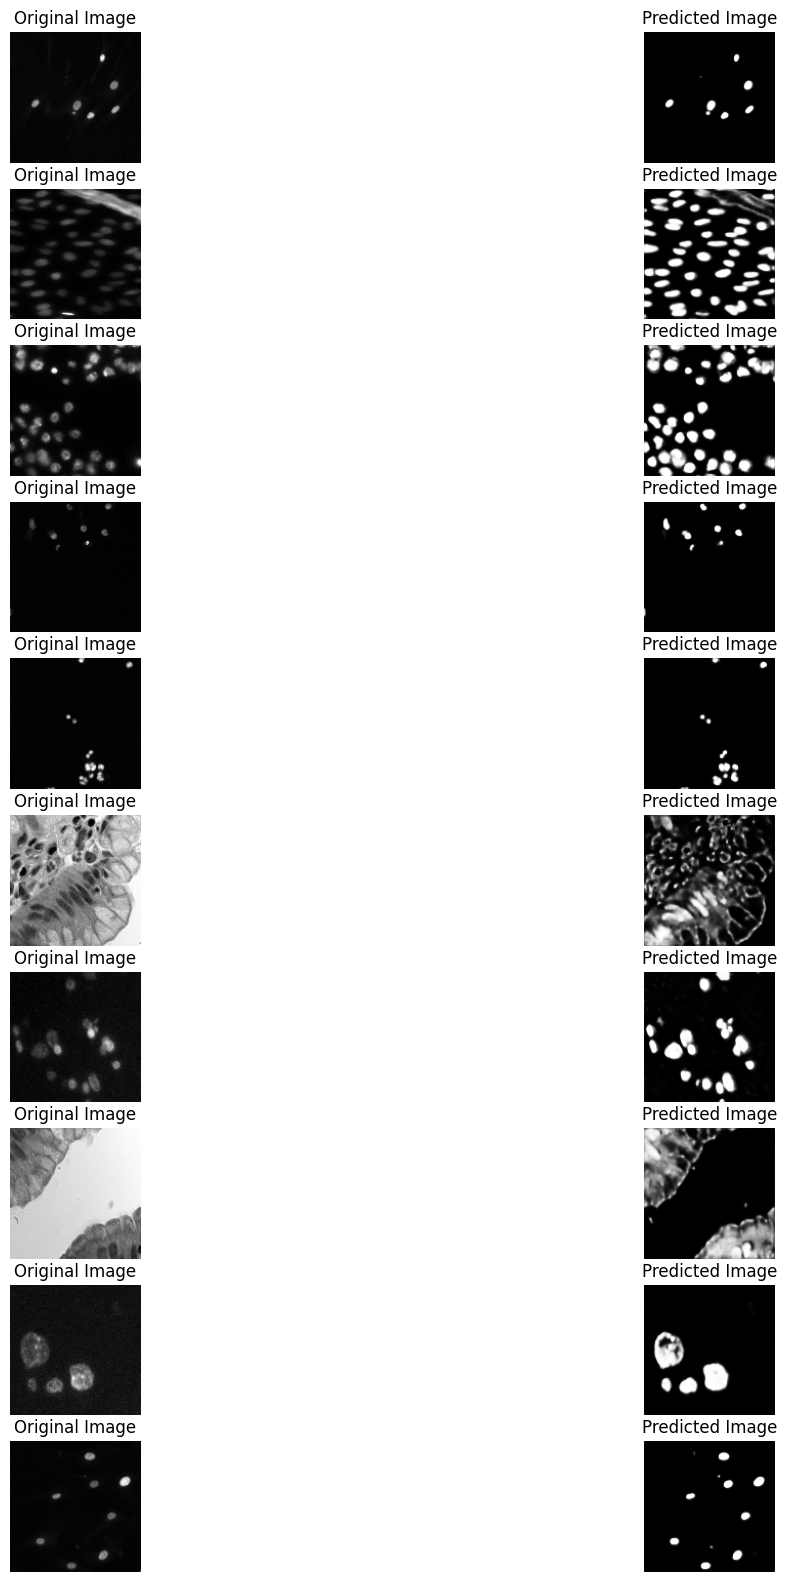

In [20]:
test_images, test_labels = load_test()
print(test_images.shape)

# Predict the first 10 images
result = unet.predict(test_images[0:10])

print(type(result))
print(len(result))

fig = plt.figure(figsize=(15, 20))  # Adjusted figure size for better visibility

for i in range(10):
    # Display original images
    plt.subplot(10, 2, 2*i + 1)  # Adjust indices for 10 rows, 2 columns, position i*2+1
    plt.imshow(test_images[i].reshape(128, 128), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')  # Optional: remove axes for clarity

    # Display predicted segmentation results
    plt.subplot(10, 2, 2*i + 2)  # Adjust indices for 10 rows, 2 columns, position i*2+2
    plt.imshow(result[i].reshape(128, 128), cmap='gray')
    plt.title('Predicted Image')
    plt.axis('off')  # Optional: remove axes for clarity

# plt.tight_layout()  # Adjust layout to fit everything without overlapping
# plt.show()


1/1 [==============================] - 7s 7s/step
<class 'numpy.ndarray'>
10


ValueError: num must be an integer with 1 <= num <= 4, not 5

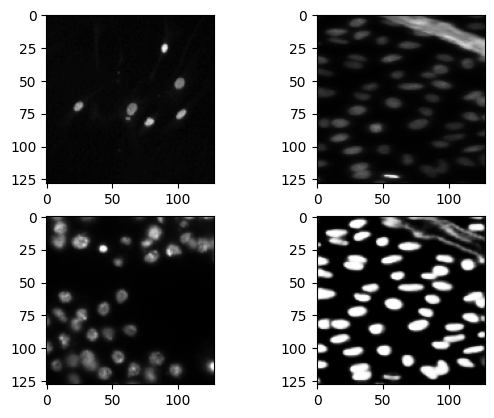

In [18]:
result=unet.predict(test_images[0:2])

print(type(result))
print(len(result))


fig=plt.figure()
for i in range(2):
  plt.subplot(2,2,i+1)
  plt.imshow(test_images[i].reshape(128, 128),cmap='gray')
  plt.subplot(2,2,i+3)
  plt.imshow(result[i].reshape(128, 128),cmap='gray')

In [ ]:
!ls

'Attention U-Net Version 2.ipynb'   Kaggle_Attention_UNET_Implementation.ipynb
 dataset			    stage1_solution_combined_masks-20240603T144926Z-001.zip
 dataset-20240603T151808Z-001.zip   stage1_test_data-20240603T145431Z-001.zip


Testing the accuracy of the model on the test set (on all 65 images):

In [21]:
# Assuming 'unet' is your compiled model and 'test_images', 'test_labels' are your test data
loss, accuracy = unet.evaluate(test_images, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

3/3 [==============================] - 15s 1s/step - loss: 0.1806 - accuracy: 0.8549
Test Loss: 0.18056678771972656
Test Accuracy: 0.8549109697341919


In [40]:
predictions = unet.predict(test_images)
# Apply a threshold to convert probabilities to binary values
binary_predictions = (predictions > 0.5).astype(np.uint8)


3/3 [==============================] - 0s 191ms/step


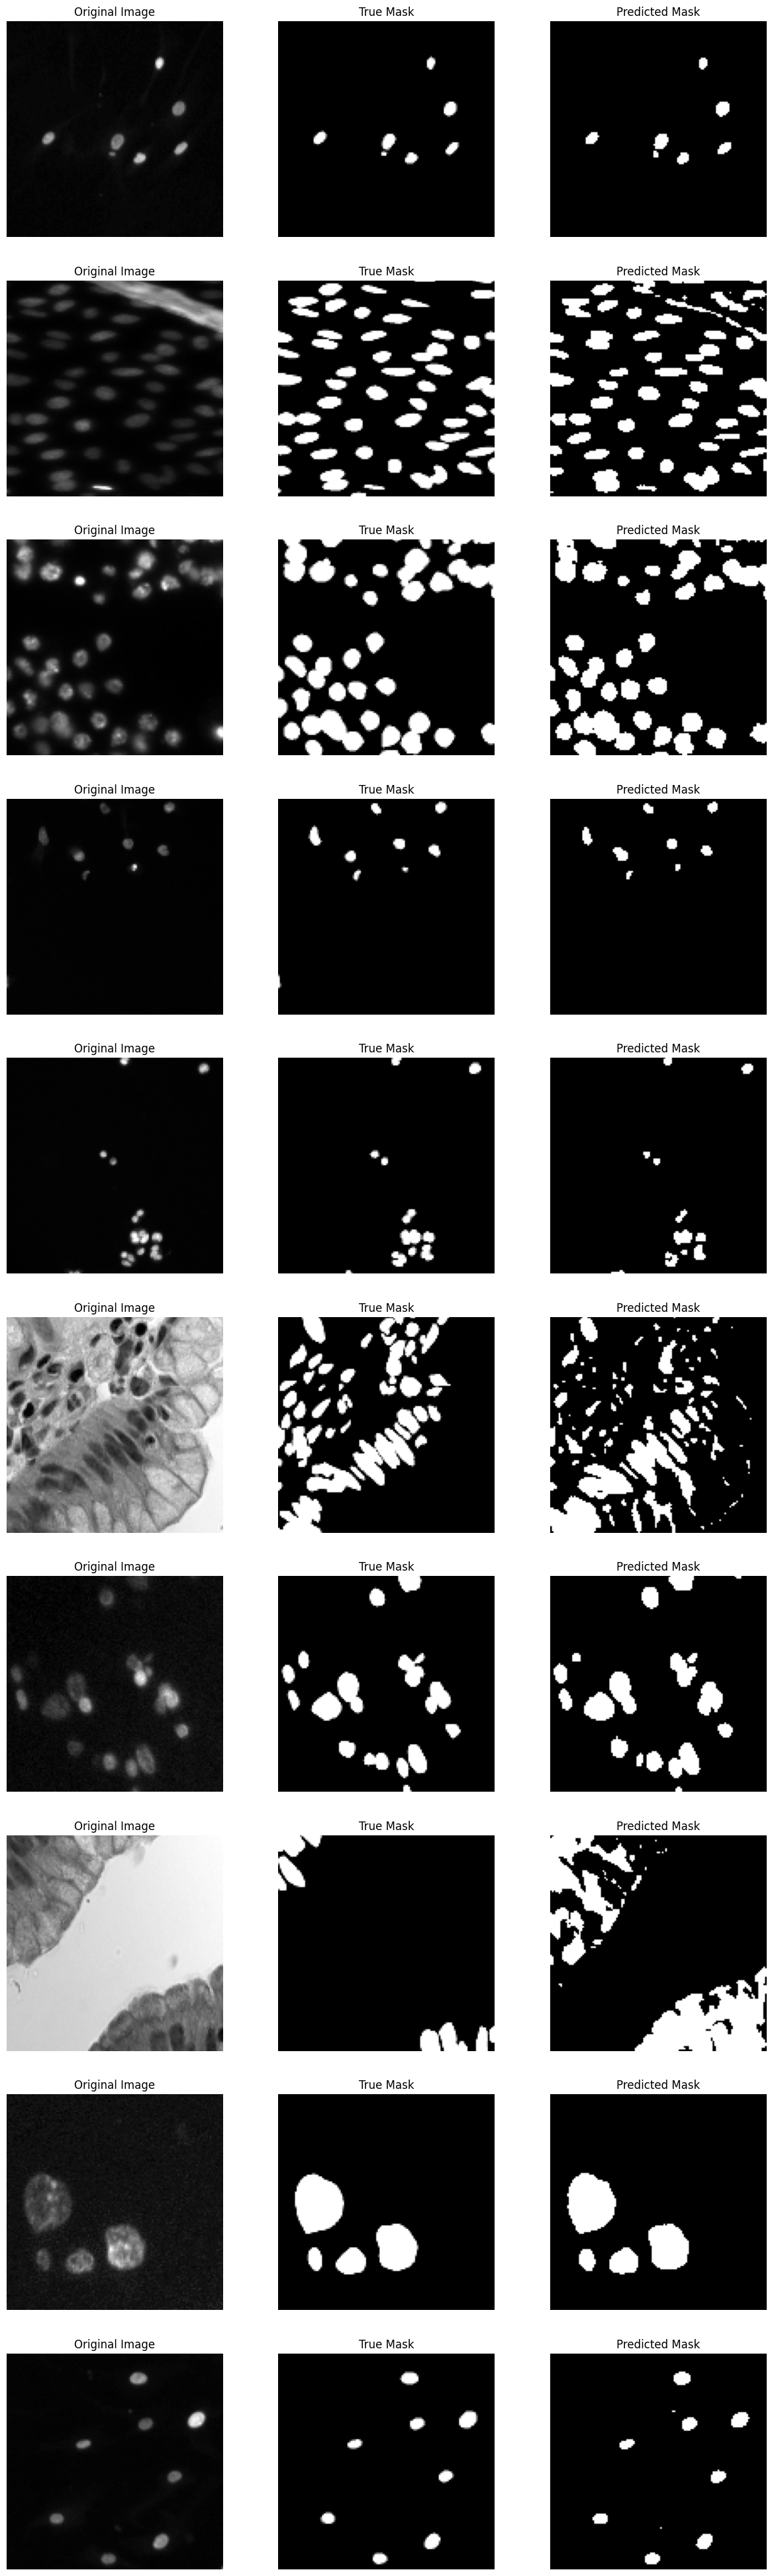

In [41]:
import matplotlib.pyplot as plt

# Set the number of examples you want to visualize
num_examples = 10

fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))
for i in range(num_examples):
    # Display the original image
    ax = axes[i, 0]
    ax.imshow(test_images[i].reshape(128, 128), cmap='gray')
    ax.set_title('Original Image')
    ax.axis('off')

    # Display the true mask
    ax = axes[i, 1]
    ax.imshow(test_labels[i].reshape(128, 128), cmap='gray')
    ax.set_title('True Mask')
    ax.axis('off')

    # Display the predicted mask
    ax = axes[i, 2]
    ax.imshow(binary_predictions[i].reshape(128, 128), cmap='gray')
    ax.set_title('Predicted Mask')
    ax.axis('off')

plt.show()
